In [69]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os
from einops import rearrange, repeat
import einops
from glob import glob
from math import log
import math
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import nibabel as nib
import nilearn as nil
from nilearn.image import index_img
from torch.utils.data import DataLoader, Subset
import random

The image resolution is: 109x91


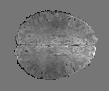

In [39]:
###--Load image with PIL and display--###
image_path = "./ground_truth.jpg"
image = Image.open(image_path)
W, H = image.size

image = image.resize((W, H))

# Print the dimensions
print(f"The image resolution is: {W}x{H}")
image.show()

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
###- DS LOCATION CONFIRMATION -###

jubin_ds = "/home/idies/workspace/Temporary/ecardillo/scratch/fmri/jubin-ds.nii"

# verify the file exists
if os.path.exists(jubin_ds):
    print(f"YES! File found at: {jubin_ds}")
else:
    print(f"Error: File not found at: {jubin_ds}")
    
# loads ds
fmri = nib.load(jubin_ds)
fmri.shape

YES! File found at: /home/idies/workspace/Temporary/ecardillo/scratch/fmri/jubin-ds.nii


(91, 109, 91, 1200)

In [42]:
###- DS METADATA -###

print("=" * 80)

# ds shape
print(f"Shape: {fmri.get_fdata().shape}")

# characteristics of ds
print(f"Header information:\n{fmri.header}") 

# gets and displays num of slices in ds (typically 1200)
num_slices = fmri.shape[-1]
print(f"Number of slices: {num_slices}")

print("=" * 80)

Shape: (91, 109, 91, 1200)
Header information:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [   4   91  109   91 1200    1    1    1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.    2.    2.    2.    0.72  0.    0.    0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'FSL5.0')
aux_file        : np.bytes_(b'')
qform_code      : mni
sform_code      : mni
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d

-4.463201462811106 5.730761050590585e-17 5.128954352209998 (91, 109)
0 255 (91, 109)


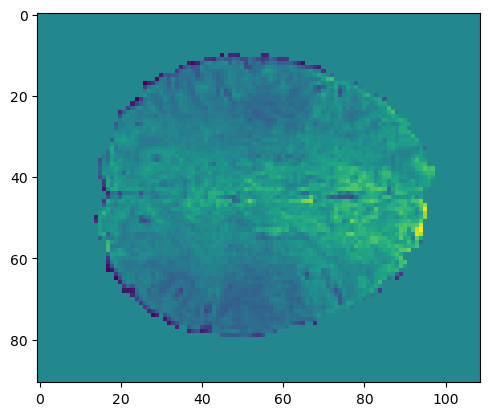

In [54]:
# gets volume
single_volume = index_img(fmri, 50)
arr = single_volume.get_fdata()

# sets timepoint
timepoint = 50

# takes 50th slice of volume, 50th timepoint
slice = arr[:,:, timepoint]

# only takes slices with intensity (everything but bg)
nonzero = slice[slice > 0]

# takes only black spaces (all bg)
back = slice == 0

# takes the mean and standard deviation of the brain component
m_, std_ = nonzero.mean(), nonzero.std()

# normalizes 
norm_slice = (slice - m_) / std_
norm_slice[back] = 0
print(norm_slice.min(), norm_slice.mean(), norm_slice.max(), norm_slice.shape)
plt.imshow(norm_slice)
np.save('ground_truth.npy', norm_slice)
min_val = norm_slice.min()
max_val = norm_slice.max()

# Stretch the values to fill the 0-255 range for the image
scaled_slice = 255 * (norm_slice - min_val) / (max_val - min_val)

# 2. Convert the scaled data to unsigned 8-bit integers (the standard for images)
image_array = scaled_slice.astype(np.uint8)
print(image_array.min(), image_array.max(), image_array.shape)

# 3. Create an image from the array and save it
img = Image.fromarray(image_array)
img.save('ground_truth.jpg')

(array([3.000e+01, 4.600e+01, 8.800e+01, 8.830e+02, 7.336e+03, 1.141e+03,
        3.250e+02, 5.900e+01, 6.000e+00, 5.000e+00]),
 array([-4.46320146, -3.50398588, -2.5447703 , -1.58555472, -0.62633914,
         0.33287644,  1.29209203,  2.25130761,  3.21052319,  4.16973877,
         5.12895435]),
 <BarContainer object of 10 artists>)

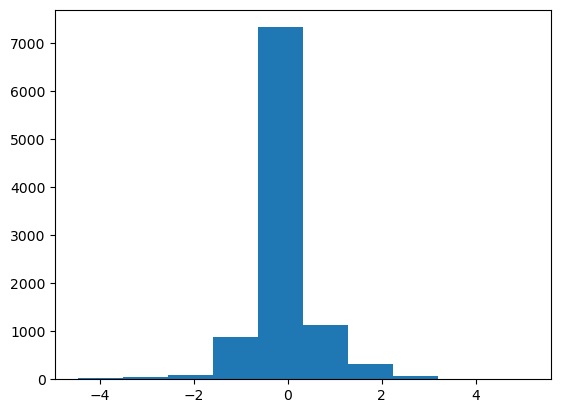

In [55]:
plt.hist(norm_slice.flatten())

In [56]:
###- BUILD DATAFRAME (NON-ZERO PIXELS ONLY) -###

# Transpose the normalized slice from (91, 109) to (109, 91) so height=109, width=91
bw_array = norm_slice.T
height, width = bw_array.shape
print(f"Shape of transposed slice: {bw_array.shape}")

# Create a boolean mask to identify the non-zero pixels (the brain region)
brain_mask = bw_array != 0

# Use np.where to get the coordinates (indices) of the brain pixels
# y_coords will be row indices (0-108), x_coords will be column indices (0-90)
y_coords, x_coords = np.where(brain_mask)

# Extract the intensity values for only the brain pixels using the mask
intensity_vals = bw_array[brain_mask]

num_brain_pixels = len(intensity_vals)
print(f"Found {num_brain_pixels} non-zero brain pixels out of {height * width} total pixels.")

# Normalize the coordinates of the brain pixels to the [0, 1] range
x_pos_norm = x_coords / (width - 1)
y_pos_norm = y_coords / (height - 1)

# To normalize intensity, find the min and max of the BRAIN region only
min_int = intensity_vals.min()
max_int = intensity_vals.max()
print(f"Intensity range of brain pixels: [{min_int:.4f}, {max_int:.4f}]")

# Normalize the brain intensities to the [0, 1] range
intensity_norm = (intensity_vals - min_int) / (max_int - min_int)

# Create the DataFrame using only the segmented brain data
df = pd.DataFrame({
    "x_pos": x_pos_norm,
    "y_pos": y_pos_norm,
    "intensity": intensity_norm
})

print("\nDataFrame created with non-zero pixels only.")
df.head()


Shape of transposed slice: (109, 91)
Found 4502 non-zero brain pixels out of 9919 total pixels.
Intensity range of brain pixels: [-4.4632, 5.1290]

DataFrame created with non-zero pixels only.


,x_pos,y_pos,intensity
0,0.555556,0.129630,0.068146
1,0.566667,0.129630,0.126463
2,0.400000,0.138889,0.261006
3,0.411111,0.138889,0.301404
4,0.422222,0.138889,0.339302


In [57]:
df.describe()

,x_pos,y_pos,intensity
count,4502.000000,4502.000000,4502.000000
mean,0.495365,0.500693,0.465297
std,0.193222,0.191691,0.104263
min,0.111111,0.129630,0.000000
25%,0.333333,0.342593,0.406371
50%,0.500000,0.500000,0.462861
75%,0.655556,0.657407,0.526206
max,0.877778,0.898148,1.000000


In [58]:
class fMRI_INRModel(torch.nn.Module):
    # nn constructor
    def __init__(self, input_size, hidden_size = 256, output_size = 1, num_hidden = 4):
        super(fMRI_INRModel, self).__init__()
        # input - 2 - x,y
        # hidden_size - 256 - num of hidden neurons
        # output - 1 - intensity
        # num_hidden - 4 - num of hidden layers

        # creates first fully-connected layer
        self.input = torch.nn.Linear(input_size, hidden_size)

        # builds hidden network layers
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        self.hidden = nn.Sequential(*layers)
        self.output = torch.nn.Linear(hidden_size, output_size)   
        # self.sig = torch.nn.Sigmoid()


    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)
        # x = self.sig(x)

        return x

In [59]:
#Pass in a frequency array and and xy grid, return cos/sin of 2x/f and 2y/f for f in freq
def fourier_encode(xy: torch.Tensor, freq: torch.Tensor) -> torch.Tensor:
    xy = xy.unsqueeze(1)
    freq1 = freq[0:len(freq)//2 ]
    freq2 = freq[len(freq)//2:]
    
    
    freq1 = torch.tensor(freq1, dtype = torch.float32).view(1, -1, 1)
    freq2 = torch.tensor(freq2, dtype = torch.float32).view(1, -1, 1)

    scaled1 = 2 * torch.pi * (1/freq1) * xy  
    scaled2 = 2 * torch.pi * (1/freq2) * xy  

    sin_feat = torch.sin(scaled1)  
    cos_feat = torch.cos(scaled2)  


    features = torch.cat([sin_feat, cos_feat], dim=-1)  
    return features.view(xy.shape[0], -1)  

In [60]:
#Dataset to customize type of positional encoding of input
class ImageINRDatasetFourier(Dataset):
    def __init__(self, dataframe, fourier = False, gaussian = False, num_freq = 1, freq_param = None, freq_file = 'freq.pkl', gauss_scale = 1):
        self.dataframe = dataframe

        if (fourier or gaussian) == False:
            #No positional encoding, just x and y
            self.x = torch.tensor(dataframe[['x_pos', 'y_pos']].values, dtype=torch.float32)
        else:
            if fourier == True:
                #fourier encoding with just cos/sin 2x and 2y
                freq = [1, 1]
            elif gaussian == True:
                #normal random sample num_freq frequencies for cos and sin to include in positional encoding
                freq = np.random.normal(0, 1, size = num_freq*2)*gauss_scale

                #Need to save these frequencies because they must also be used for pos encoding inputs at inference time
                pickle.dump(freq, open(freq_file, "wb"))
            else:
                #if you want to pass in custom frequencies
                freq = freq_param

            x = dataframe['x_pos']
            y = dataframe['y_pos']
            xy = torch.tensor(np.stack([x, y], axis=-1), dtype = torch.float32)
            self.x = fourier_encode(xy, freq)

        self.y = torch.tensor(dataframe[['intensity']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [72]:
# creates a seed used to randomize training pixel grid
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    
    # if you are using multi-GPU, these lines ensure deterministic results
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"SEED SET TO: {seed}")

In [73]:
#Function to train with different encoding types, set model_type to use different encodings
#STAF is a new INR that uses trainable parameter sinusoidal activation functions, just wanted to experiment with it: https://arxiv.org/abs/2502.00869
from tqdm import tqdm
import pickle
def train( num_freq, model_type, model_file = 'checkpoint.pth', loss_file = 'losses', freq_file = 'freq.pkl', gauss_scale = 1, visualize_split_flag=True):
    epoch_losses = []
    min_loss = 100
    
    if model_type == 'fourier':
        data = ImageINRDatasetFourier(df, fourier = True, num_freq = 1)
        model = fMRI_INRModel(input_size = 4).to(device)
    elif model_type == 'standard':
        data = ImageINRDatasetFourier(df)
        model = fMRI_INRModel(input_size = 2).to(device)
    elif model_type == 'gaussian':
        data = ImageINRDatasetFourier(df, gaussian = True, num_freq = num_freq, freq_file = freq_file, gauss_scale = gauss_scale)
        model = fMRI_INRModel(input_size = 4*num_freq).to(device)
    elif model_type == 'STAF':
        data = ImageINRDatasetFourier(df)
        model = INR(2, 256, 4, 1).to(device)
    else:
        print('invalid model_type')
        return

      #--- DEV SET SPLIT ---#

    # gets ds size (expected 9919)
    ds_size = len(data)
    # indexes length of ds
    indices = list(range(ds_size))

    # randomizes indices
    np.random.shuffle(indices)
    
    # calculates size of training set (80% of full set)
    train_split = int(np.floor(0.8 * ds_size))
    
    # calculates size of validation set (10% of full set)
    val_split = int(np.floor(0.9 * ds_size))

    # 0 - train_split .. (80%)
    train_indices = indices[:train_split]
    # train_split - val_split .. (10%)
    val_indices = indices[train_split:val_split]
    # val_split - END .. (10%)
    test_indices = indices[val_split:]

    def visualize_split(full_df, train_indices):
        # pixel grid of the training dataset
        train_df = full_df.iloc[train_indices]

        # init figure
        plt.figure(figsize=(12, 6))
        
        # plots ALL pixels 
        plt.subplot(1, 2, 1)
        plt.scatter(full_df['x_pos'], full_df['y_pos'], s=1, alpha=0.5)
        plt.title(f'All Brain Pixels ({len(full_df)} points out of {len(full_df)})')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.gca().invert_yaxis()
        plt.axis('equal')
    
        # plots ONLY TRAINING pixels
        plt.subplot(1, 2, 2)
        plt.scatter(train_df['x_pos'], train_df['y_pos'], s=1, alpha=0.5, color='orange')
        plt.title(f'Training Set Pixels ({len(train_df)} points out of {len(full_df)})')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.gca().invert_yaxis()
        plt.axis('equal')

        # displays figure
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    
    # shows comparison when set to True
    if visualize_split_flag:
        visualize_split(data.dataframe, train_indices)

    # creates subsets
    train_dataset = Subset(data, train_indices)
    val_dataset = Subset(data, val_indices)
    test_dataset = Subset(data, test_indices) # TEST - *not used in training

    print(f"DS SPLIT: {len(train_dataset)} TRAIN, {len(val_dataset)} VAL, {len(test_dataset)} TEST")

    
    train_dataloader = DataLoader(data, batch_size=8192, shuffle=True)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    num_epochs = 400

    for epoch in tqdm(range(num_epochs)):
        model.train()

        epoch_loss = 0

        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)


            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()


        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss: {epoch_loss / len(train_dataloader)}")
            epoch_losses.append(epoch_loss)
            pickle.dump(epoch_losses, open(f"{loss_file}_losses.pkl", "wb"))
            if epoch_loss < min_loss:

                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    # Add other relevant information as needed
                }
                

                torch.save(checkpoint, model_file)


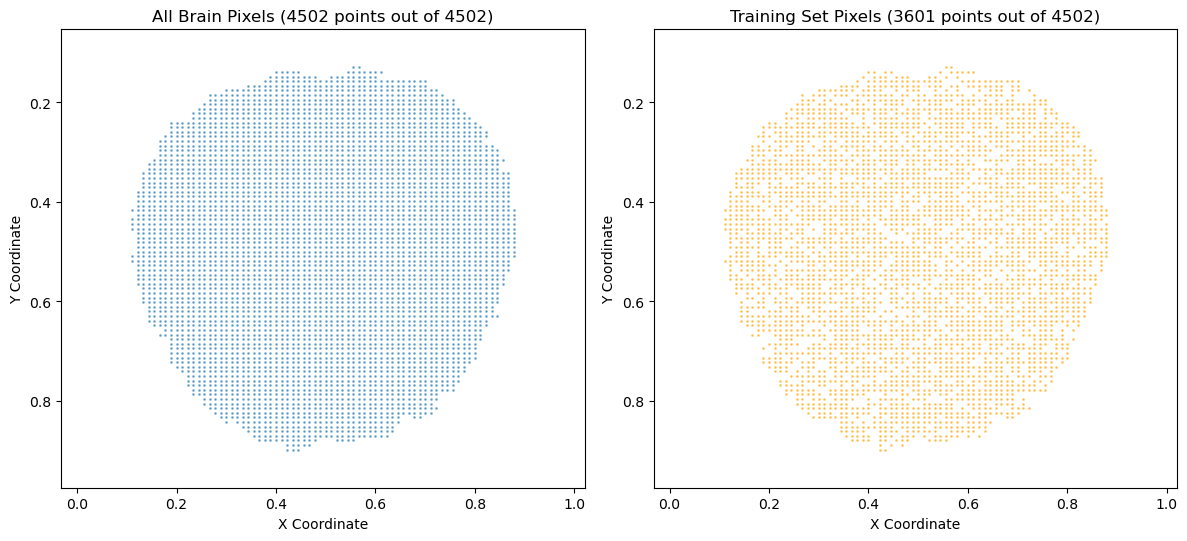

DS SPLIT: 3601 TRAIN, 450 VAL, 451 TEST


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0, Loss: 0.194110706448555


 50%|█████     | 202/400 [00:08<00:12, 16.11it/s]

Epoch 200, Loss: 0.004209253937005997


100%|██████████| 400/400 [00:16<00:00, 24.12it/s]


In [75]:
train(num_freq = 256, model_type = 'gaussian', model_file ='NZ_run.pth', loss_file = 'NZ_loss', freq_file = 'NZ.pkl', gauss_scale = 10)

Reconstructing for dimensions: 109x91
Shape of encoded coordinate grid: torch.Size([9919, 1024])
reconstructed


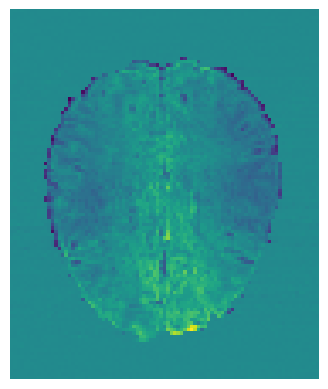

gt


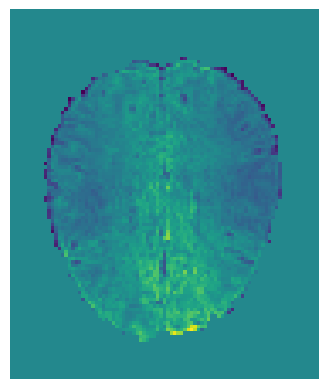

dif


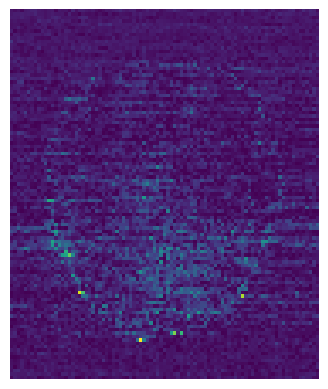

In [77]:
# Re-define the model architecture for inference
num_freq = 256
model = fMRI_INRModel(input_size = 4*num_freq) 

# Define path to the saved model checkpoint 
path = './NZ_run.pth' 
checkpoint = torch.load(path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Get the original image dimensions (after transpose)
H, W = norm_slice.T.shape
print(f"Reconstructing for dimensions: {H}x{W}")

# Create a coordinate grid for the entire image space
x = np.linspace(0, 1, W)
y = np.linspace(0, 1, H)
xx, yy = np.meshgrid(x, y)

# *** FIX: Removed the incorrect .T transpose on xx and yy ***
# This ensures the coordinate grid is created in the correct row-major order
X = torch.tensor(np.stack([xx, yy], axis=-1).reshape(-1, 2), dtype = torch.float32)

# Load the frequencies used during training for positional encoding
with open('./NZ.pkl', 'rb') as file:
    freq = pickle.load(file)

# Apply the same fourier encoding to the full coordinate grid
X_encoded = fourier_encode(X, freq = freq)
print(f"Shape of encoded coordinate grid: {X_encoded.shape}")

# Perform inference
with torch.no_grad():
    Y = model(X_encoded) 

# Reshape the output back into an image
# Note: The output Y is normalized between 0 and 1. We need to un-normalize it.
min_int = norm_slice[norm_slice != 0].min()
max_int = norm_slice.max()
image_normalized_output = Y.reshape(H, W, 1)
image_unnormalized = (image_normalized_output * (max_int - min_int)) + min_int

# Create the ground truth image from the original DataFrame for comparison
gt_array = np.zeros((H, W))
y_indices = (df['y_pos'] * (H - 1)).round().astype(int).values
x_indices = (df['x_pos'] * (W - 1)).round().astype(int).values
gt_intensities_normalized = df['intensity'].values
gt_array[y_indices, x_indices] = gt_intensities_normalized
gt_tensor_normalized = torch.from_numpy(gt_array).unsqueeze(-1)

# Calculate the difference image
diff_image = torch.abs(gt_tensor_normalized - image_normalized_output).squeeze()

print('reconstructed')
plt.imshow(image)
plt.axis('off')
plt.show()

print('gt')
plt.imshow(gt_df)
plt.axis('off')
plt.show()

print('dif')
plt.imshow(gt_df_diff)
plt.axis('off')
plt.show()